* FTLE para el 01-Oct-2019
* delta0 (separación inicial en deg) 
1/64 y 1/8
* tiempo de integración.
15d y 30d

* backward o forward?

* FSLE Vero: df=10*d0, 

* Lat: 32-38
* Lon: 330-345 (-30, -15)

We then instatiate a `FieldSet` with the velocity field data from GlobCurrent dataset. https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description

In [1]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
import matplotlib.ticker as mticker

In [2]:
1./64.

0.015625

In [12]:
# Parameters:

#Particle_AZO_grid100000_notides_Dec_week01_hourly.nc
grid_name = "1-64grid"
nyear = 2019
nmonth = 10
simu_length = 15. # monthly # days
domain = [360.-30, 360.-15, 32, 38] #lomin, lomax, lamin, lamax

# Defining grid of starting particles:

if grid_name == "1-8grid":
    step = .125 # degrees
elif grid_name == "1-64grid":
    step = 0.015625 # 1./64degrees
else:
    print("Error")
    fszfasgasg
    
lons, lats = np.meshgrid(np.arange(domain[0], domain[1]+step, step), np.arange(domain[2], domain[3]+step, step))
lons.shape[0]*lons.shape[1]

data_path = '../validation/'
fname = 'datos_Laura.nc'

# Checking input data:

In [4]:
ds_in = xr.open_dataset(data_path + fname)
ds_in

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 140, time: 92)
Coordinates:
  * time       (time) datetime64[ns] 2019-10-01 2019-10-02 ... 2019-12-31
  * latitude   (latitude) float32 30.12 30.38 30.62 30.88 ... 39.62 39.88 40.12
  * longitude  (longitude) float32 325.1 325.4 325.6 325.9 ... 359.4 359.6 359.9
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2020-07-16T10:25:20Z
    date_issued:                     2020-07-16T10:25:20Z
    date_modified:                   2020-07-16T10:25:20Z
    geospatial_lat_max:              40.125
    geospatial_lat_min:              30.125
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -0.125
    geospatial_lon_min:              -34.875
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2020-07-16 10:25:21Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Altika Drifting Phase, Cryosat-2, Haiyan...
    processing_level:                L4
    product_version:                 vJul2020
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.3_DUACS_DT2018_baseline
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2020-03-07T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2020-03-07T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...

In [6]:
(ds_in.longitude[1] - ds_in.longitude[0]).values # data resolution

array(0.25, dtype=float32)

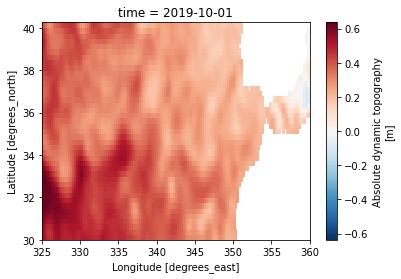

In [8]:
ds_in.adt[0,:,:].plot()

## Zooming in release area:

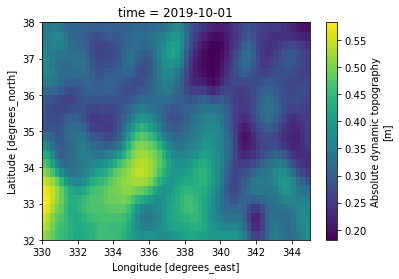

In [23]:
# as lon and lat depend only on each, need to do where in 2 parts
ds_in_zoom = ds_in.where((ds_in.longitude>domain[0]) & (ds_in.longitude<domain[1]), drop=True)
ds_in_zoom = ds_in_zoom.where((ds_in_zoom.latitude>domain[2])  & (ds_in_zoom.latitude<domain[3]), drop=True)
ds_in_zoom.adt[0,:,:].plot()

# --> islands not masked

# Running the simulation:

In [4]:
variables = {'U': 'ugos', 'V': 'vgos'}

filenames = {'U': data_path + fname, 'V': data_path + fname}

dimensions = {'U': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'},
              'V': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

#

In [5]:
outdir = '../examples/'

# Define start date:
start_day = 1 #[1, 8, 15, 22]

outname = outdir + "Particle_AZO_fFTLE_" + grid_name + "_" + str(nmonth).zfill(2) + str(start_day).zfill(2) + "_" + str(simu_length)[0:2] + "d"

In [6]:
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=datetime(nyear, nmonth, start_day, 0, 0)) #30))

output_file = pset.ParticleFile(name=outname, outputdt=timedelta(hours=6))

#minutes=6*60
pset.execute(AdvectionRK4, runtime=timedelta(days=simu_length), dt=timedelta(hours=6),
      output_file=output_file) #recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},

output_file.export()  # export the trajectory data to a netcdf file


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/f101bd9f00d49175c692b32fbbb8574b_0.so
INFO: Temporary output files are stored in ../examples/out-TZZCBCHE.
INFO: You can use "parcels_convert_npydir_to_netcdf ../examples/out-TZZCBCHE" to convert these to a NetCDF file during the run.
100% (1296000.0 of 1296000.0) |##########| Elapsed Time: 0:01:04 Time:  0:01:04


# Checking the outputs:

In [7]:
ds = xr.open_dataset(outdir + 'Particle_AZO_fFTLE_1-64grid_1001_15d.nc')

In [8]:
ds

<xarray.Dataset>
Dimensions:     (obs: 61, traj: 369985)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1
    parcels_mesh:           spherical

## Plotting

### All particles at all times:

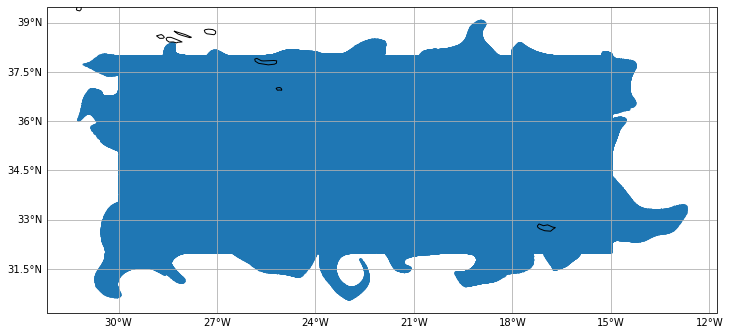

In [22]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'], ds['lat'], s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### All particles at last timestep:

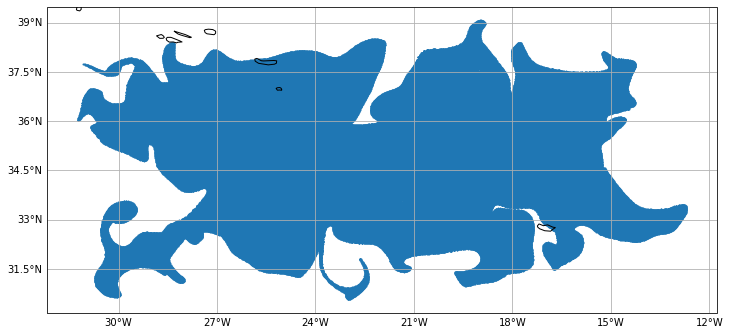

In [21]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
